# Earthquake Surrogate

### Import Libraries

In [4]:
import os
import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb



In [5]:
csv_file = "Formatted_ETAS_Output.csv"
df = pd.read_csv(csv_file, sep=',', lineterminator='\n')

In [6]:
summary_stats = df.describe(include="all")
print(summary_stats)

           Date        Time          Year            X             Y  \
count     32001       32001  32001.000000  32001.00000  32001.000000   
unique    19127       26803           NaN          NaN           NaN   
top     4/26/64  0:31:11.00           NaN          NaN           NaN   
freq         10           5           NaN          NaN           NaN   
mean        NaN         NaN   1991.924790   -117.54676     34.810868   
std         NaN         NaN     18.407271      2.11036      2.388448   
min         NaN         NaN   1960.002196   -123.48700     29.080400   
25%         NaN         NaN   1975.851679   -118.73330     33.343000   
50%         NaN         NaN   1992.311728   -117.20600     34.587100   
75%         NaN         NaN   2007.784510   -116.10520     36.820000   
max         NaN         NaN   2023.487118   -113.24630     39.475100   

           Magnitude           Z\r  
count   32001.000000  32001.000000  
unique           NaN           NaN  
top              NaN    

### Data Table Transformation

Variables were made to be suitable for machine learning models. For example the date was put into a format where the day, month, and year were separated. Furthermore we extrapolate from the dates the quarter of the year the earthquake occurred. Feature encoding was also performed, specifically ordinal encoding.

In [7]:
new_df = df.copy()

# Convert "Date" column to datetime in the new DataFrame
new_df["Date"] = pd.to_datetime(new_df["Date"], errors="coerce", format="%m/%d/%y")
# Adjust two-digit year values to four-digit format in the new DataFrame
new_df.loc[new_df["Date"].dt.year > pd.Timestamp.now().year, "Date"] -= pd.DateOffset(years=100)

# Extract components from the "Date" column in the new DataFrame
new_df["Day"] = new_df["Date"].dt.day
new_df["Month"] = new_df["Date"].dt.month
new_df["Year"] = new_df["Date"].dt.year
new_df["DayOfWeek"] = new_df["Date"].dt.dayofweek
new_df["Quarter"] = new_df["Date"].dt.quarter

# Convert "Time" column to datetime in the new DataFrame
new_df["Time"] = pd.to_datetime(new_df["Time"], format="%H:%M:%S.%f")

# Extract time components in the new DataFrame
new_df["Hour"] = new_df["Time"].dt.hour
new_df["Minute"] = new_df["Time"].dt.minute
new_df["Second"] = new_df["Time"].dt.second
new_df["Millisecond"] = new_df["Time"].dt.microsecond // 1000

# Drop the original "Time" column from the new DataFrame
new_df = new_df.drop("Time", axis=1)

# Drop the "Date" column from the new DataFrame
new_df = new_df.drop("Date", axis=1)
new_df = new_df.drop("Year", axis=1)

new_df.head()

,X,Y,Magnitude,Z\r,Day,Month,DayOfWeek,Quarter,Hour,Minute,Second,Millisecond
0,-119.0502,33.9790,6.50,8.2474,31,12,3,4,0,3,9,0
1,-115.6222,33.0793,4.25,7.9322,2,1,5,1,0,8,49,0
2,-115.6323,33.1220,3.03,8.4015,2,1,5,1,0,10,31,0
3,-115.5851,33.0745,3.03,7.9678,2,1,5,1,0,10,32,0
4,-115.6256,33.0290,3.08,7.9737,2,1,5,1,0,11,7,0


### Model Training And Preprocessing

Once the data was transformed and made suitable for our models, we split the data using a 70% training set to 30% testing set split.

For certain models, relative influence was able to be calculated in order to see which predictor variables affected the specific model the most. This calculation and visualizations can be seen specifically for the XGBoost, Linear Regression, and Random Forest models.

In [8]:
X = new_df.drop("Magnitude", axis=1)  # Features
y = new_df["Magnitude"]  # Target variable

# Create a StandardScaler object
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Print the data to verify the changes
print("Scaled X_train:")
print(X_train)

print("y_train:")
print(y_train)

print("Scaled X_test:")
print(X_test)

print("y_test:")
print(y_test)


Scaled X_train:
[[ 0.57704818 -1.19823102  1.49530055 ... -1.17876566 -0.83204313
   0.        ]
 [-0.30276807  1.3833182  -0.79177252 ...  0.78103568  1.0807553
   0.        ]
 [ 0.01798791  0.38587671 -1.28610312 ... -1.00584201 -0.89000671
   0.        ]
 ...
 [-0.40360552 -0.5749714   1.65289841 ... -0.89055958  1.54446401
   0.        ]
 [ 0.72015396  0.9207512   1.45023324 ... -0.37178863  0.84890095
   0.        ]
 [-1.95810392  1.04719511  1.58157829 ...  1.70329514  1.02279171
   0.        ]]
y_train:
31932    3.21
31187    4.40
14148    4.23
23611    3.07
23500    3.51
         ... 
29802    3.24
5390     3.05
860      3.14
15795    3.29
23654    5.13
Name: Magnitude, Length: 22400, dtype: float64
Scaled X_test:
[[ 1.04958158 -1.03921315  1.44085029 ...  0.95395933  1.19668248
   0.        ]
 [-0.04205018  0.70303321  0.13277997 ... -1.3516893  -0.426298
   0.        ]
 [-0.2884101   1.43117429 -1.3567102  ... -0.48707107  1.25464607
   0.        ]
 ...
 [-1.14211665  0.05515

### XGB Regressor

A variation of a gradient boosting algorithm best suited for regression and classification tasks through decision trees

In [9]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

val_score_xgb = xgb_model.score(X_test, y_test)
print("XGB Regressor R^2:", val_score_xgb)

predicted = xgb_model.predict(X_test)
MAE_xgb = mean_absolute_error(y_test, predicted)
print("XGB Regressor MAE:", MAE_xgb)

mean_squared_score_xgb = mean_squared_error(y_test, predicted)
print("XGB Regressor MSE:", mean_squared_score_xgb)


XGB Regressor R^2: -0.07775879866078106
XGB Regressor MAE: 0.35240284276075656
XGB Regressor MSE: 0.23095209796608107


#### XGB Regressor - Actual vs. Predicted

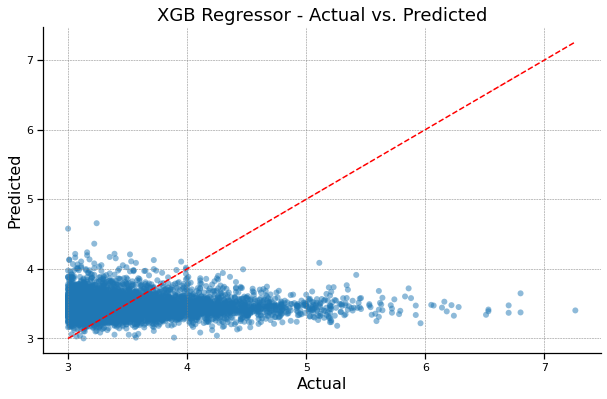

In [11]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predicted, color='#1f77b4', alpha=0.5, edgecolor='none')
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='dashed')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGB Regressor - Actual vs. Predicted')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(True)
plt.show()

#### Feature Importance In XGB Regressor

In [12]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Get the feature importances
feature_importance = xgb_model.feature_importances_
feature_names = X_test_df.columns

# Create a DataFrame to store the feature importances
feature_importance_df_1 = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df_1 = feature_importance_df_1.sort_values(by='Importance', ascending=False)

print("Relative Influence of Features:")
print(feature_importance_df_1)

Relative Influence of Features:
        Feature  Importance
2           Z\r    0.126057
1             Y    0.123776
7          Hour    0.112574
8        Minute    0.111738
4         Month    0.110232
0             X    0.108772
3           Day    0.107846
9        Second    0.103845
5     DayOfWeek    0.095160
6       Quarter    0.000000
10  Millisecond    0.000000


) missing from current font.l\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


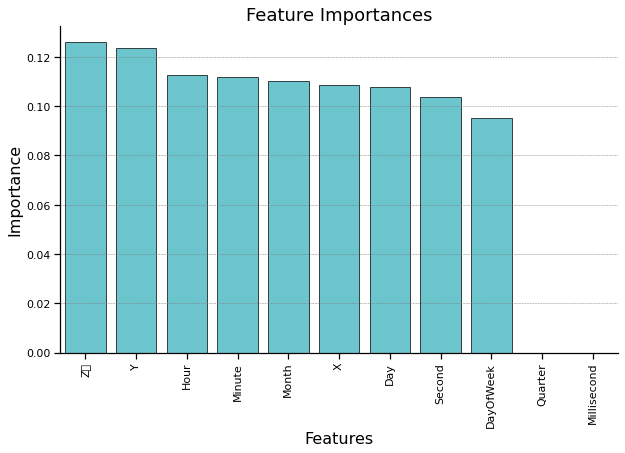

In [13]:
# Plot the feature importances in a bar plot
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df_1, x='Feature', y='Importance', color='#17becf',  alpha=0.7, edgecolor='black')

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)


plt.grid(axis='x')
plt.show()

### Support Vector Regression

A model used for regression tasks specifically through finding a function that approximates the relationship between the input features and the target variable, while controlling the margin of error.

In [14]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2)

regr.fit(X_train, y_train)

SVR(epsilon=0.2)

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

r2_svr = regr.score(X_test, y_test)
print("SVR R^2:", r2_svr)

predicted = regr.predict(X_test)

MAE_svr = mean_absolute_error(y_test, predicted)
print("SVR MAE:", MAE_svr)
mean_squared_score_svr = mean_squared_error(y_test, predicted)
print("SVR MSE:", mean_squared_score_svr)

SVR R^2: -0.04471690218943092
SVR MAE: 0.3235623886053753
SVR MSE: 0.22387157557060747


#### SVR - Actual vs. Predicted

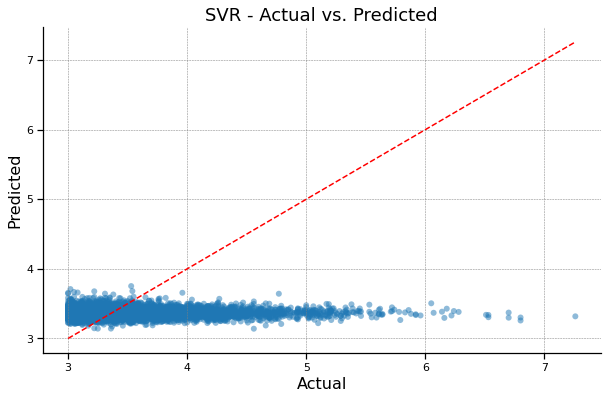

In [16]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=predicted, color='#1f77b4', alpha=0.5, edgecolor='none')
sns.lineplot(x=np.linspace(min(y_test), max(y_test)), y=np.linspace(min(y_test), max(y_test)), color='red', linestyle='dashed')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR - Actual vs. Predicted')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(True)
plt.show()

### MLP Regressor

The multi-layered perceptron regression model is an artificial neural network used for regression tasks. It is used in approximating complex non-linear relationships and mapping feature values to corresponding output values.


In [17]:
from sklearn.neural_network import MLPRegressor

smlp = MLPRegressor(hidden_layer_sizes=1000, activation='relu', solver='adam', batch_size=32, learning_rate='invscaling', max_iter=10000, alpha=0.0001).fit(X_train, y_train)


In [18]:
from sklearn.metrics import mean_squared_error

R2_mlp = smlp.score(X_test, y_test)
print("MLP Regressor R^2:", R2_mlp)

predicted = smlp.predict(X_test)

MAE_mlp = mean_absolute_error(y_test, predicted)
print("MLP Regressor MAE:", MAE_mlp)
mean_squared_score_mlp = mean_squared_error(y_test, predicted)
print("MLP Regressor MSE:", mean_squared_score_mlp)

MLP Regressor R^2: -0.06420248395389594
MLP Regressor MAE: 0.33416011477004043
MLP Regressor MSE: 0.22804712579036424


#### MLP Regressor - Actual vs. Predicted

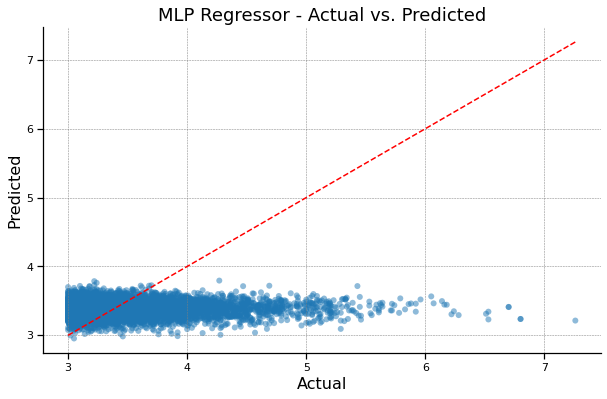

In [19]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=predicted, color='#1f77b4', alpha=0.5, edgecolor='none')
sns.lineplot(x=np.linspace(min(y_test), max(y_test)), y=np.linspace(min(y_test), max(y_test)), color='red', linestyle='dashed')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('MLP Regressor - Actual vs. Predicted')

plt.grid(color='gray', linestyle='--', linewidth=0.5)
sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(True)
plt.show()

### Linear Regression

This is a simple model that attempts to minimize the sum of squared errors. The final model predicts along a linear slope line that goes through the data points. 

In [20]:
from sklearn.linear_model import LinearRegression

clf_1 = LinearRegression().fit(X_train, y_train)

In [21]:
from sklearn.metrics import mean_squared_error

val_acc_ln = clf_1.score(X_test, y_test)

print("Linear Regression R^2:", val_acc_ln)


predicted = clf_1.predict(X_test)
MAE_ln = mean_absolute_error(y_test, predicted)
print("Linear Regression MAE:", MAE_ln)
mean_squared_score_ln = mean_squared_error(y_test, predicted)
print("Linear Regression MSE", mean_squared_score_ln)

Linear Regression R^2: -0.0007016649741236058
Linear Regression MAE: 0.3404332764766683
Linear Regression MSE 0.2144395844887611


#### Linear Regression - Actual vs. Predicted

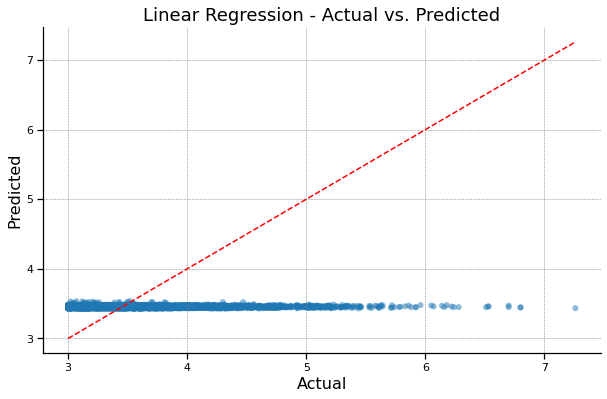

In [22]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})
plt.figure(figsize=(10, 6))

# Scatter plot for the actual vs. predicted values
sns.scatterplot(x=y_test, y=predicted, color='#1f77b4', alpha=0.5, edgecolor='none')
sns.lineplot(x=np.linspace(min(y_test), max(y_test)), y=np.linspace(min(y_test), max(y_test)), color='red', linestyle='dashed')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression - Actual vs. Predicted')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(True)
plt.show()

#### Feature Importance In Linear Regression

In [23]:
# Get the coefficients (feature importances) from the trained model
coefficients = clf_1.coef_

# Create a DataFrame to store the feature importances
feature_importance_df_2 = pd.DataFrame({'Feature': X_test_df.columns, 'Importance': coefficients})

# Sort the features by importance in descending order
feature_importance_df_2 = feature_importance_df_2.sort_values(by='Importance', ascending=False)

print("Relative Influence of Features:")
print(feature_importance_df_2)

Relative Influence of Features:
        Feature  Importance
4         Month    0.024669
2           Z\r    0.007264
9        Second    0.003136
3           Day    0.000082
10  Millisecond    0.000000
0             X   -0.001522
1             Y   -0.001735
8        Minute   -0.004456
5     DayOfWeek   -0.004879
6       Quarter   -0.006226
7          Hour   -0.014279


) missing from current font.l\Temp\ipykernel_19916\816986420.py:10: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.l\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


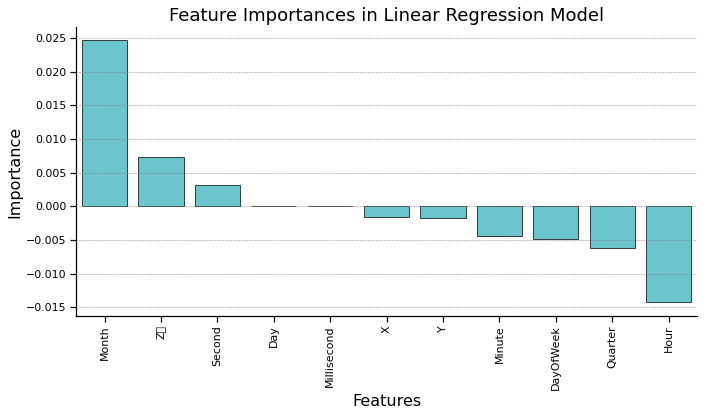

In [24]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})
plt.figure(figsize=(10, 6))

sns.barplot(data=feature_importance_df_2, x='Feature', y='Importance', color='#17becf', alpha=0.7, edgecolor='black')

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Linear Regression Model')
plt.tight_layout()


plt.grid(color='gray', linestyle='--', linewidth=0.5)
sns.despine()

plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(axis='x')
plt.show()

### Random Forest

This is a supervised machine learning model that uses the mean result from decision trees in order to predict an output.

In [25]:
clf_2 = RandomForestRegressor(max_depth=2, random_state=42).fit(X_train, y_train)

In [26]:
from sklearn.metrics import mean_squared_error

val_acc_rf = clf_2.score(X_test, y_test)

print("Random Forest R^2:", val_acc_rf)


predicted = clf_2.predict(X_test)
MAE_rf = mean_absolute_error(y_test, predicted)
print("Random Forest MAE:", MAE_rf)
mean_squared_score_rf = mean_squared_error(y_test, predicted)
print("Random Forest MSE", mean_squared_score_rf)

Random Forest R^2: -0.0014886206464004292
Random Forest MAE: 0.3405884869516936
Random Forest MSE 0.2146082206100755


#### Random Forest - Actual vs. Predicted

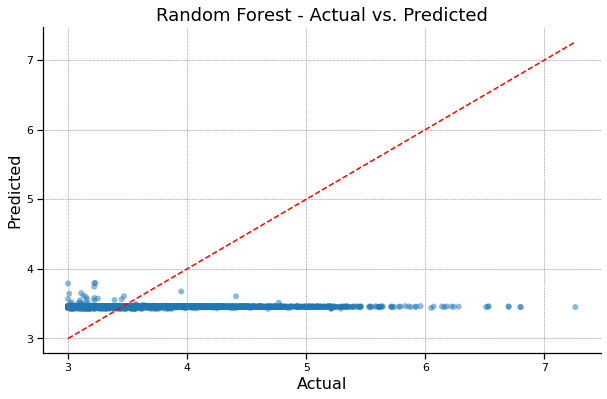

In [27]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=predicted, color='#1f77b4', alpha=0.5, edgecolor='none')
sns.lineplot(x=np.linspace(min(y_test), max(y_test)), y=np.linspace(min(y_test), max(y_test)), color='red', linestyle='dashed')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest - Actual vs. Predicted')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(True)
plt.show()

#### Feature Importance In Random Forest

In [28]:
# Get the feature importances from the trained model
feature_importance = clf_2.feature_importances_
feature_names = X_test_df.columns

# Create a DataFrame to store the feature importances
feature_importance_df_3 = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df_3 = feature_importance_df_3.sort_values(by='Importance', ascending=False)

print("Relative Influence of Features:")
print(feature_importance_df_3)

Relative Influence of Features:
        Feature  Importance
1             Y    0.421510
8        Minute    0.129558
2           Z\r    0.127120
0             X    0.123066
9        Second    0.070646
5     DayOfWeek    0.066045
3           Day    0.034490
4         Month    0.013680
7          Hour    0.010584
6       Quarter    0.003302
10  Millisecond    0.000000


) missing from current font.l\Temp\ipykernel_19916\139572493.py:10: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.l\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


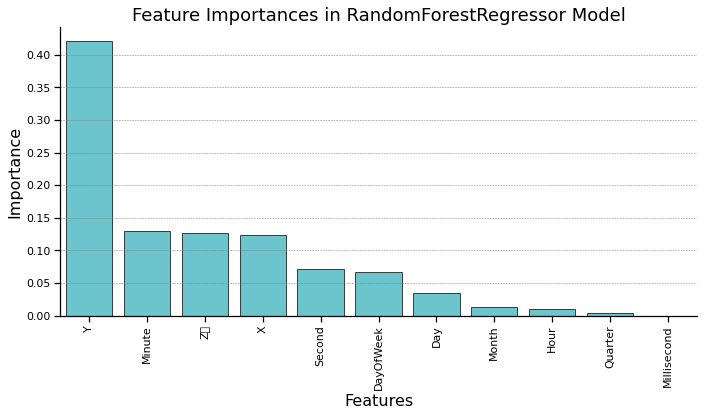

In [29]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})
plt.figure(figsize=(10, 6))

sns.barplot(data=feature_importance_df_3, x='Feature', y='Importance', color='#17becf', alpha=0.7, edgecolor='black')

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in RandomForestRegressor Model')
plt.tight_layout()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().patch.set_facecolor('none')
plt.gca().set_frame_on(True)

plt.grid(axis='x')
plt.show()

In [30]:
model_names = ['XGBoost', 'SVR', 'MLP Regressor', 'Linear Regression', 'Random Forest']
mae_scores = {'XGBoost': MAE_xgb, 'SVR': MAE_svr, 'MLP Regressor': MAE_mlp,
              'Linear Regression': MAE_ln, 'Random Forest': MAE_rf}
mse_scores = {'XGBoost': mean_squared_score_xgb, 'SVR': mean_squared_score_svr, 'MLP Regressor': mean_squared_score_mlp,
              'Linear Regression': mean_squared_score_ln, 'Random Forest': mean_squared_score_rf}
r2_scores = {'XGBoost': val_score_xgb, 'SVR': r2_svr, 'MLP Regressor': R2_mlp,
             'Linear Regression': val_acc_ln, 'Random Forest': val_acc_rf}

results_df = pd.DataFrame({'Model': model_names, 'MAE': [mae_scores[model] for model in model_names],
                           'MSE': [mse_scores[model] for model in model_names], 'R^2': [r2_scores[model] for model in model_names]})
print(results_df)

               Model       MAE       MSE       R^2
0            XGBoost  0.352403  0.230952 -0.077759
1                SVR  0.323562  0.223872 -0.044717
2      MLP Regressor  0.334160  0.228047 -0.064202
3  Linear Regression  0.340433  0.214440 -0.000702
4      Random Forest  0.340588  0.214608 -0.001489


### Plotting Error Values

In [31]:
# Create a DataFrame from the scores dictionaries
results_df = pd.DataFrame({'Model': model_names, 'MAE': [mae_scores[model] for model in model_names],
                           'MSE': [mse_scores[model] for model in model_names], 'R^2': [r2_scores[model] for model in model_names]})

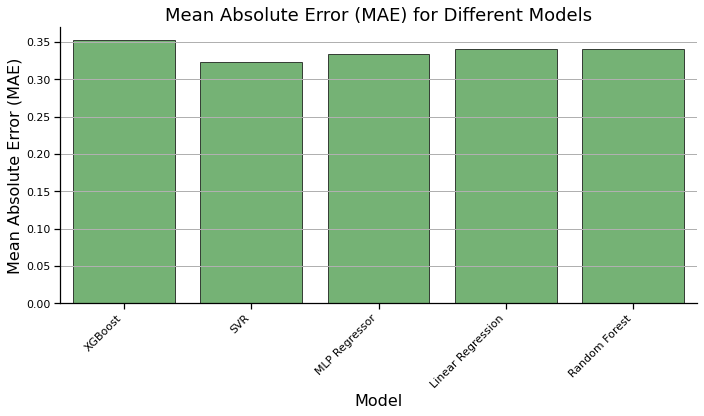

In [32]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})

# Plot MAE scores
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='MAE', color='#2ca02c',alpha=0.7, edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Mean Absolute Error (MAE) for Different Models')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
sns.despine()

plt.grid(axis='y')
plt.show()


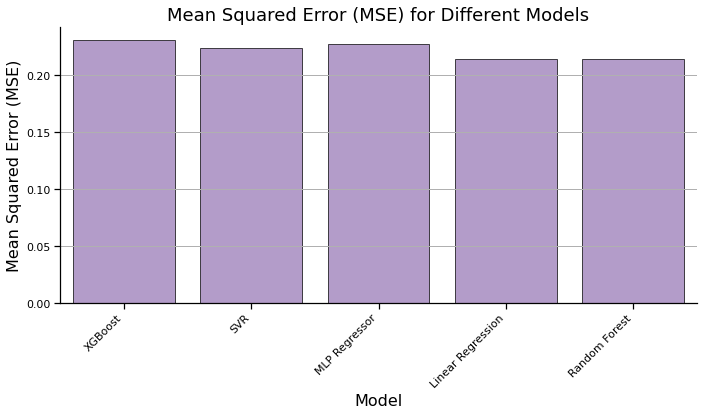

In [33]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})

# Plot MSE scores
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='MSE', color='#9467bd',alpha=0.7, edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) for Different Models')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
sns.despine()

plt.grid(axis='y')
plt.show()

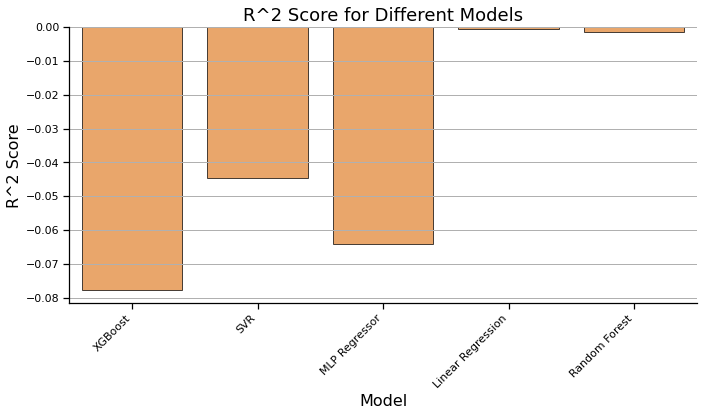

In [37]:
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})

# Plot R^2 scores
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='R^2', color='#ff7f0e',alpha=0.7, edgecolor='black')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('R^2 Score for Different Models')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
sns.despine()

plt.grid(axis='y')
plt.show()

In [34]:
feature_importance_df_1.rename(columns={'Importance': 'Importance_XGBoost'}, inplace=True)
feature_importance_df_2.rename(columns={'Importance': 'Importance_LinearRegression'}, inplace=True)
feature_importance_df_3.rename(columns={'Importance': 'Importance_RandomForest'}, inplace=True)

merged_df = pd.merge(feature_importance_df_1, feature_importance_df_2, on='Feature', how='outer')
merged_df = pd.merge(merged_df, feature_importance_df_3, on='Feature', how='outer')

print(merged_df)


        Feature  Importance_XGBoost  Importance_LinearRegression  \
0           Z\r            0.126057                     0.007264   
1             Y            0.123776                    -0.001735   
2          Hour            0.112574                    -0.014279   
3        Minute            0.111738                    -0.004456   
4         Month            0.110232                     0.024669   
5             X            0.108772                    -0.001522   
6           Day            0.107846                     0.000082   
7        Second            0.103845                     0.003136   
8     DayOfWeek            0.095160                    -0.004879   
9       Quarter            0.000000                    -0.006226   
10  Millisecond            0.000000                     0.000000   

    Importance_RandomForest  
0                  0.127120  
1                  0.421510  
2                  0.010584  
3                  0.129558  
4                  0.013680  
5  

### Comparison of Models

) missing from current font.l\Temp\ipykernel_19916\1467680380.py:18: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.l\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


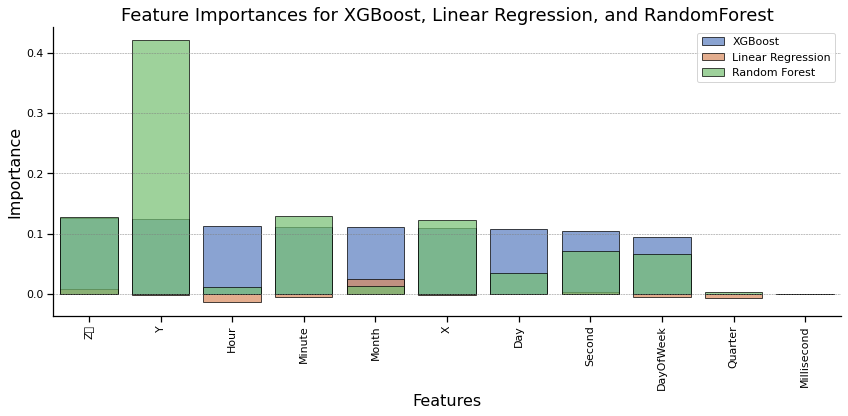

In [36]:
# Set a custom color palette for the plot
custom_palette = sns.color_palette("muted")  # Using Seaborn's muted color palette
sns.set_context("notebook", rc={"font.size": 14, "axes.labelsize": 16, "axes.titlesize": 18})

plt.figure(figsize=(12, 6))

# Bar plot for feature importances using Seaborn
sns.barplot(data=merged_df, x='Feature', y='Importance_XGBoost', color=custom_palette[0], alpha=0.7, label='XGBoost', edgecolor='black')
sns.barplot(data=merged_df, x='Feature', y='Importance_LinearRegression', color=custom_palette[1], alpha=0.7, label='Linear Regression', edgecolor='black')
sns.barplot(data=merged_df, x='Feature', y='Importance_RandomForest', color=custom_palette[2], alpha=0.7, label='Random Forest', edgecolor='black')

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances for XGBoost, Linear Regression, and RandomForest')

plt.legend()
plt.tight_layout()
plt.grid(axis='y',color='gray', linestyle='--', linewidth=0.5)

sns.despine()
plt.gca().set_frame_on(True)
plt.gca().patch.set_facecolor('none')

plt.show()


## Results

Earthquakes as a whole are a fairly random and unpredictable phenomena. We found that deterministic models were not suitable for predicting earthquake magnitudes as seen by our low MAE, MSE, and R^2 values. Though relative influence was an interesting factor to consider, the earthquake data does not fit these models. We hope to find success in the near future through exploring generative models as suitable models for earthquake prediction.